In [2]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits


ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python 3.11 from "c:\Users\eliot\anaconda3\python.exe"
  * The NumPy version is: "1.24.3"

and make sure that they are the versions you expect.

Please carefully study the information and documentation linked above.
This is unlikely to be a NumPy issue but will be caused by a bad install
or environment on your machine.

Original error was: DLL load failed while importing _multiarray_umath: Le module spécifié est introuvable.


## Résolution scqubit

In [54]:
def get_eigen_sc(EJ=30.02, EC=1.2, ng=0.3, n_cut=31, N_eigen=3):
    transmon = scqubits.Transmon(EJ, EC, ng, n_cut)
    H = transmon.hamiltonian()
    vals, vecs = transmon.eigensys()
    vals = vals - vals[0]
    return vals[1:N_eigen+1]

## Résolution qubits

On commence par coder le Hamiltonien dans la base de charge. Les états seront tronqués de |-N> à |+N> qui est en paramètre de l'hamiltonien. 

$$H = 4E_C (\hat{n}-n_g)^2 - E_J \cos(\phi)$$

In [55]:
def Hamiltonian_qutip(EJ=30.02, EC=1.2, ng=0.3, n_cut=31, N_eigen=3):
    dim = 2 * n_cut + 1

    n_list = np.arange(-n_cut, n_cut + 1)
    n_op = qt.Qobj(np.diag(n_list))

    op_couple = qt.tunneling(dim, 1)

    H = 4 * EC * (n_op - ng) ** 2 - 0.5 * EJ * op_couple

    return H

In [56]:
def get_eigen_qubits(EJ=30.02, EC=1.2, ng=0.3, n_cut=31, N_eigen=3):
    H = Hamiltonian_qutip(EJ, EC, ng, n_cut, N_eigen)
    energies = H.eigenenergies()
    energies = energies - energies[0]
    return energies[1 : N_eigen + 1]

## Résolution numpy

In [57]:
def Hamiltonian_numpy(EJ=30.02, EC=1.2, ng=0.3, n_cut=31, N_eigen=3):
    diag = [4 * EC * (i - ng) ** 2 for i in range(-n_cut, n_cut + 1)]
    diag_off = [-EJ / 2 for i in range(-n_cut, n_cut)]
    diag_on = [-EJ / 2 for i in range(-n_cut, n_cut)]
    H = np.diag(diag, k=0) + np.diag(diag_on, k=1) + np.diag(diag_off, k=-1)
    return H

In [58]:
def get_eigen_numpy(EJ=30.02, EC=1.2, ng=0.3, n_cut=31, N_eigen=3):
    H = Hamiltonian_numpy(EJ, EC, ng, n_cut, N_eigen)

    eigen_values_H = np.linalg.eigvalsh(H)

    energies = eigen_values_H - eigen_values_H[0]
    return energies[1 : N_eigen + 1]

## Plot des résultats

In [ ]:
def plot_transmon(ng_max, N_eigen=3, n_cut=31,EC = 1.02):
    NG = np.linspace(-ng_max, ng_max, 100)
    Res = np.zeros((N_eigen, 3, 100))
    i = 0
    for ng in NG:
        E_sc = get_eigen_sc(ng=ng, N_eigen=N_eigen, n_cut=n_cut,EC = EC)
        E_qu = get_eigen_qubits(ng=ng, N_eigen=N_eigen, n_cut=n_cut, EC= EC)
        E_np = get_eigen_numpy(ng=ng, N_eigen=N_eigen, n_cut=n_cut,EC= EC)
        Res[:, :, i] = np.array([E_sc, E_qu, E_np]).T
        i += 1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10, 5))
    for i in range(N_eigen):
        ax1.plot(NG, Res[i][0][:], label=f"Niveau {i}")
        ax2.plot(NG, Res[i][1][:], label=f"Niveau {i}")
        ax3.plot(NG, Res[i][2][:], label=f"Niveau {i}")
    ax1.set(
        xlabel=r"$n_g$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec scqubits",
    )
    ax2.set(
        xlabel=r"$n_g$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec qubits",
    )
    ax3.set(
        xlabel=r"$n_g$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec numpy",
    )
    legend_title = f"Ratio $E_J/E_C = {30/EC:.1f}$"
    
    ax3.legend(
        bbox_to_anchor=(1.05, 1), 
        loc='upper left', 
        title=legend_title,
        title_fontsize='12'
    )
    plt.tight_layout()
    plt.show()

$$ T_m = \begin{pmatrix} \alpha_1 & \beta_2 & 0 & \dots \ \beta_2 & \alpha_2 & \beta_3 & 0 \ 0 & \beta_3 & \alpha_3 & \ddots \ \vdots & 0 & \ddots & \ddots \end{pmatrix} $$

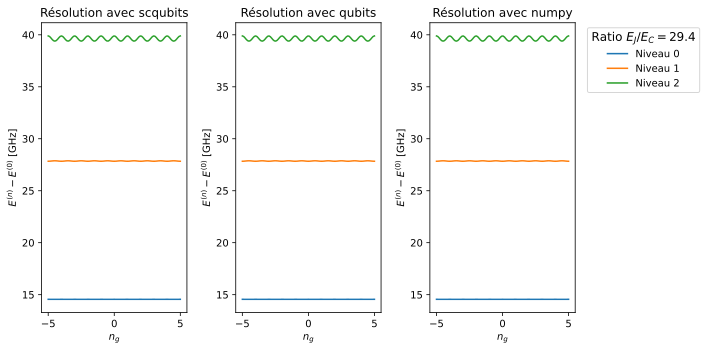

In [62]:
plot_transmon(5,EC = 1.02)

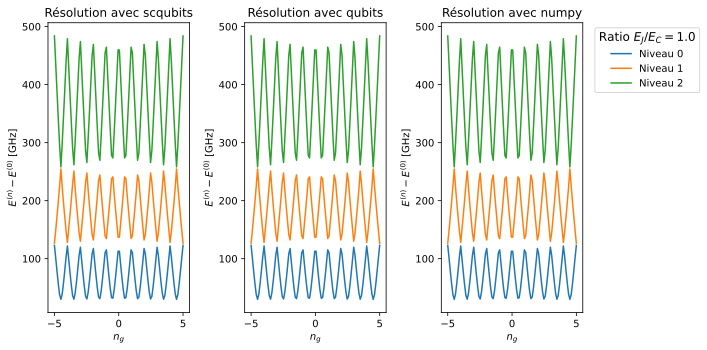

In [63]:
plot_transmon(5,EC = 30)

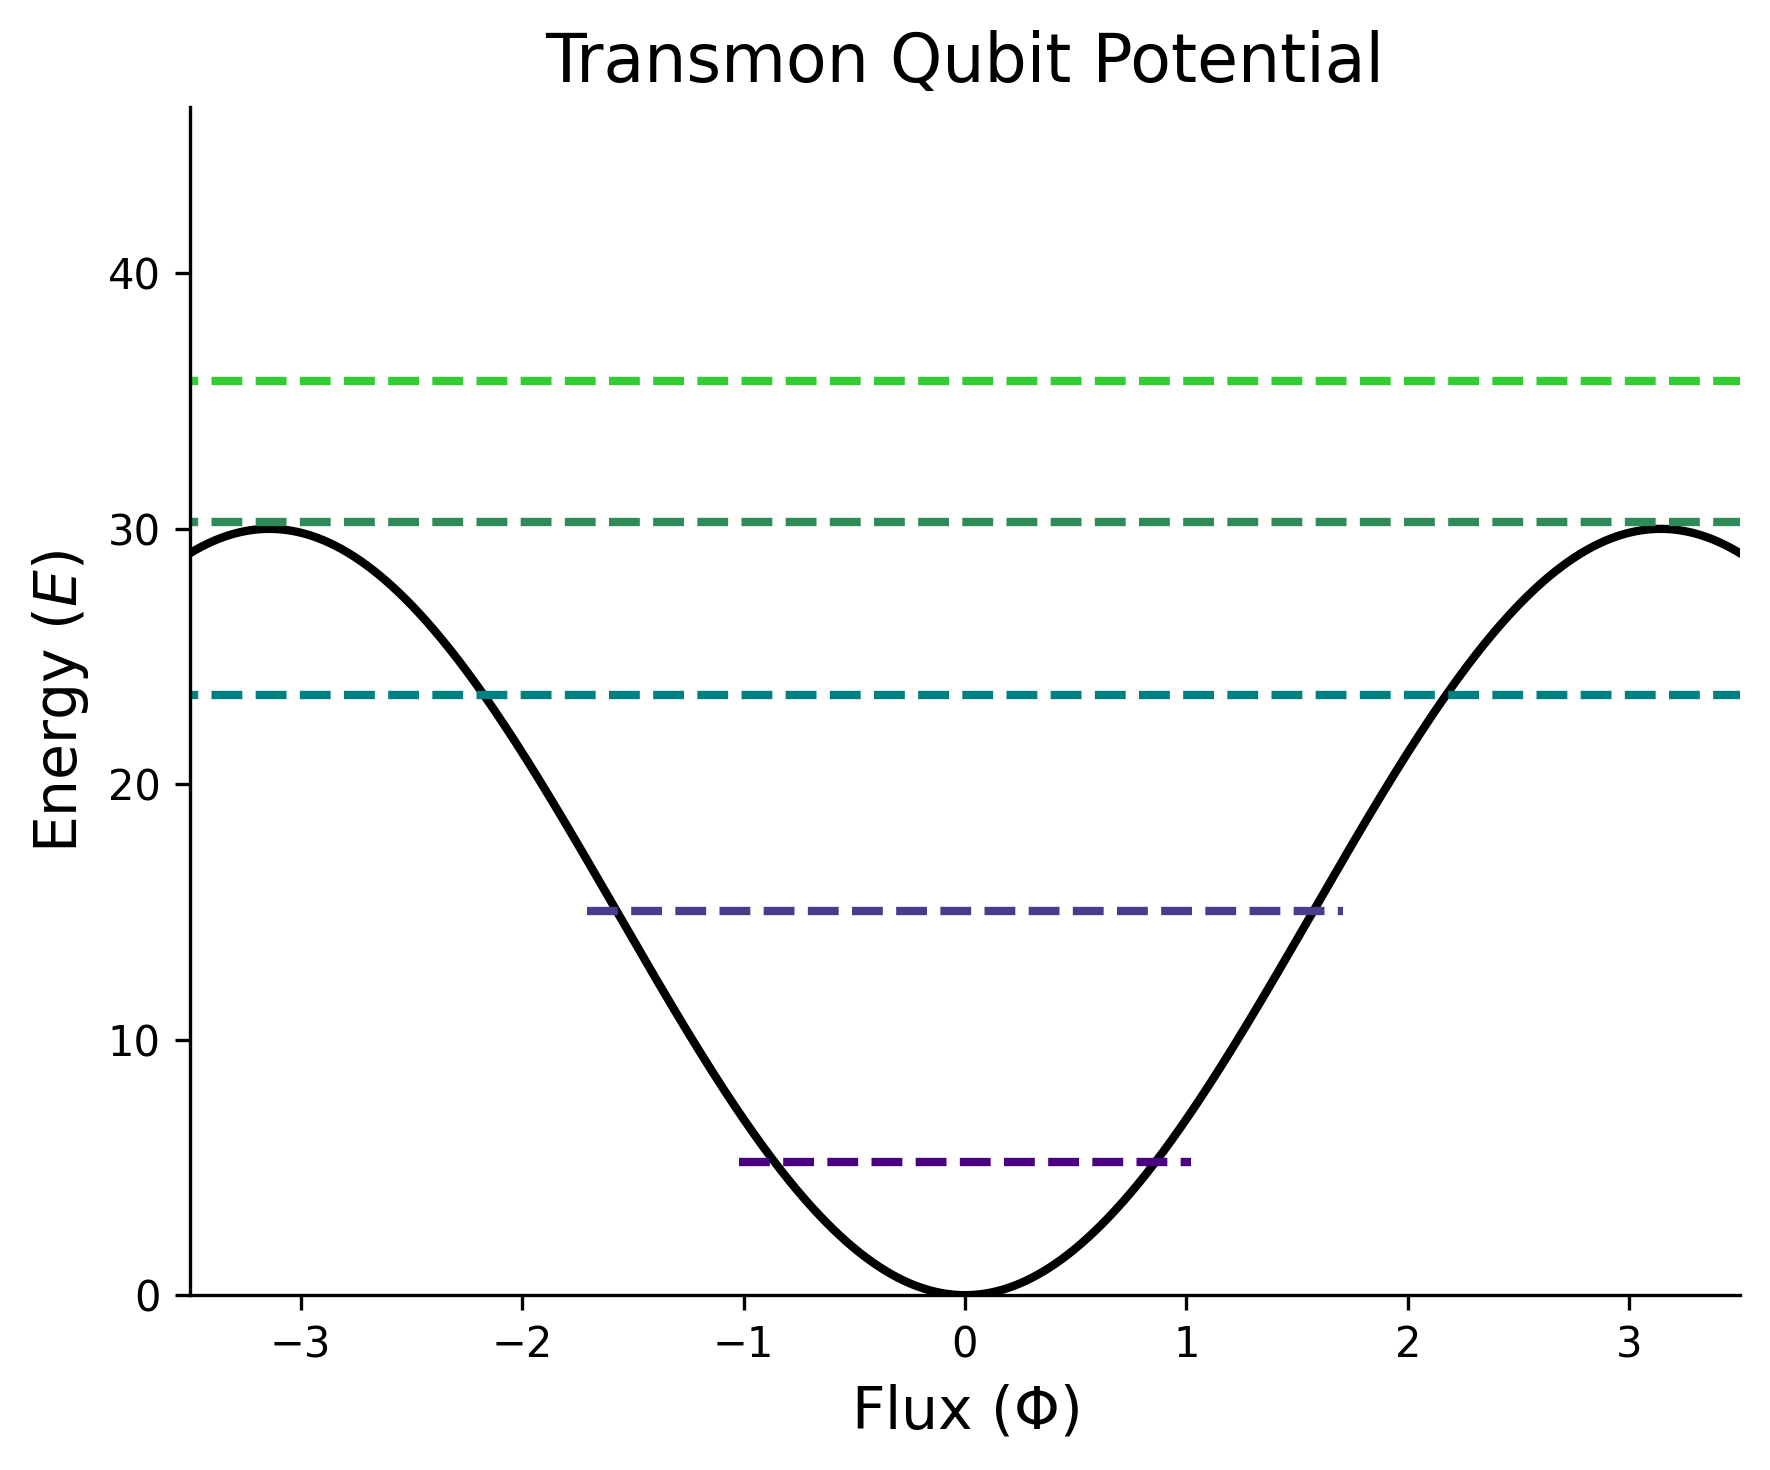

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal

# --- 1. Paramètres du Transmon ---
# On choisit un ratio EJ/EC qui rend l'anharmonicité visible à l'oeil nu
Ej = 15.0  
Ec = 1.0   
num_levels = 5  # Nombre de niveaux à afficher

# --- 2. Construction de la simulation (Grille Phi) ---
N = 2000       # Nombre de points
phi_max = 4.0  # Étendue en flux (Phi)
phi = np.linspace(-phi_max, phi_max, N)
d_phi = phi[1] - phi[0]

# Potentiel du Transmon : Ej * (1 - cos(phi))
# On le décale pour que le minimum soit à 0, comme sur ton schema LC
potential = Ej * (1 - np.cos(phi))

# --- 3. Résolution de l'Hamiltonien (Méthode des différences finies) ---
# H = 4Ec * (-d^2/dphi^2) + V(phi)
# Diagonale principale (Terme cinétique + Potentiel)
diag = 4.0 * Ec * (2.0 / d_phi**2) * np.ones(N) + potential
# Diagonales secondaires (Terme cinétique couplage voisins)
off_diag = -4.0 * Ec * (1.0 / d_phi**2) * np.ones(N - 1)

# Calcul des valeurs propres (Energies) et vecteurs propres
energies, wavefunctions = eigh_tridiagonal(diag, off_diag, select='i', select_range=(0, num_levels-1))

# --- 4. Affichage (Style PowerPoint) ---
fig, ax = plt.subplots(figsize=(6, 5), dpi=300)

# A. Tracer le Potentiel (Ligne noire épaisse)
ax.plot(phi, potential, color='black', linewidth=2, label=r'$E_J(1-\cos\phi)$')

# B. Tracer les Niveaux d'énergie (Lignes pointillées colorées)
# Couleurs similaires à ta slide (Violet -> Bleu -> Vert)
colors = ['#4b0082', '#483d8b', '#008080', '#2e8b57', '#32cd32'] 

for i in range(num_levels):
    E = energies[i]
    color = colors[i] if i < len(colors) else 'gray'
    
    # On trace la ligne seulement à l'intérieur du puits (là où E > V)
    # pour faire "propre" comme sur ton image
    mask = potential < (E + 2.0) # On laisse un peu de marge sur les côtés
    
    ax.hlines(E, phi[mask].min(), phi[mask].max(), 
              colors=color, linestyles='--', linewidth=2)
    
    # (Optionnel) : Afficher E0, E1... à droite
    # ax.text(phi[mask].max() + 0.1, E, f'$|{i}\\rangle$', va='center', color=color, fontsize=12)

# C. Mise en forme
ax.set_xlabel(r'Flux ($\Phi$)', fontsize=14)
ax.set_ylabel(r'Energy ($E$)', fontsize=14)
ax.set_title('Transmon Qubit Potential', fontsize=16)

# Limites pour bien voir la courbure du cosinus
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(0, energies[-1] * 1.3)

# Enlever le cadre inutile pour le style "Slide"
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('transmon_levels.png', transparent=True)
plt.show()

In [1]:
pip install scqubits

   ---------------------------------------- 0.0/6.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.6 MB ? eta -:--:--
   ------ --------------------------------- 1.0/6.6 MB 2.2 MB/s eta 0:00:03
   --------- ------------------------------ 1.6/6.6 MB 2.5 MB/s eta 0:00:03
   -------------- ------------------------- 2.4/6.6 MB 2.8 MB/s eta 0:00:02
   -------------------- ------------------- 3.4/6.6 MB 3.2 MB/s eta 0:00:01
   ------------------------- -------------- 4.2/6.6 MB 3.4 MB/s eta 0:00:01
   --------------------------------- ------ 5.5/6.6 MB 3.7 MB/s eta 0:00:01
   -------------------------------------- - 6.3/6.6 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 6.6/6.6 MB 3.9 MB/s  0:00:01
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/10.8 MB 7.5 MB/s eta 0:00:02
   ----------- --------------------------

  You can safely remove it manually.
  You can safely remove it manually.


--- Paramètres ---
EJ : 25.0
EC : 1.0


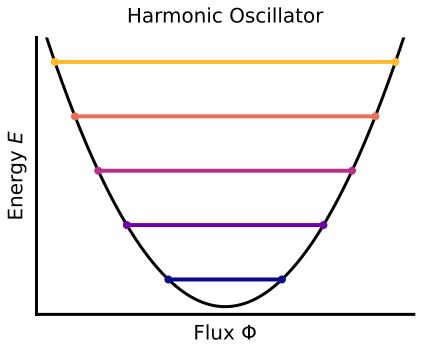

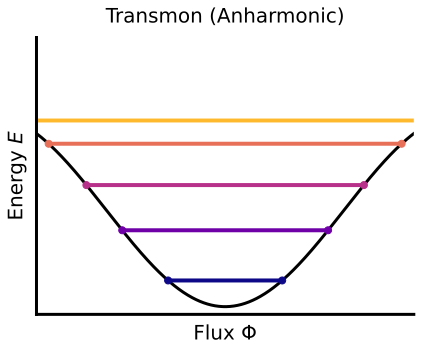

In [19]:
import scqubits as squbit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# --- 1. PARAMÈTRES (INCHANGÉS) ---
Ec_val = 1.0
ratio_EjEc = 25.0
Ej_val = ratio_EjEc * Ec_val

E_plasma = np.sqrt(8.0 * Ej_val * Ec_val)

print(f"--- Paramètres ---")
print(f"EJ : {Ej_val}")
print(f"EC : {Ec_val}")

# --- 2. CONFIGURATION GRAPHIQUE ---
num_levels = 5    
xlims = [-2.5, 2.5] 
ylims = [-2, E_plasma * (num_levels + 0.5) * 0.9] 
fig_size = (6, 5)

# Palette de couleurs
colors = cm.plasma(np.linspace(0, 0.85, num_levels))

# --- 3. FONCTION DE TRACÉ AJUSTÉE ---
def plot_confined_levels(ax, x_arr, V_arr, energies, system_type="harmonic"):
    # 1. Le Potentiel (Noir, épais)
    ax.plot(x_arr, V_arr, color='black', linewidth=3.0)
    
    # 2. Les Niveaux
    for i in range(len(energies)):
        E = energies[i]
        if E > ylims[1]: continue

        # Calcul des points d'arrêt
        if system_type == "harmonic":
            val = 2 * E / Ej_val
            x_turn = np.sqrt(val) if val > 0 else 0
        else:
            arg = 1 - E/Ej_val
            if arg < -1: x_turn = np.pi 
            elif arg > 1: x_turn = 0
            else: x_turn = np.arccos(arg)

        # Tracé de la ligne
        c = colors[i]
        ax.hlines(E, -x_turn, x_turn, color=c, linewidth=4.0, linestyle='-')
        # Bulles aux extrémités
        ax.scatter([-x_turn, x_turn], [E, E], color=c, s=50, zorder=5)

    # 3. Style Uniformisé
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    # Titre (Taille 20, pas de gras)
    title = "Harmonic Oscillator" if system_type == "harmonic" else "Transmon (Anharmonic)"
    ax.set_title(title, fontsize=20, pad=15)
    
    # Labels (Taille 20, pas de gras)
    ax.set_xlabel(r"Flux $\Phi$", fontsize=20, labelpad=10)
    ax.set_ylabel(r"Energy $E$", fontsize=20, labelpad=10)
    
    # Suppression chiffres
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Cadres (Spines) Épaissis (On garde ça pour la lisibilité de loin)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(3.0)
    ax.spines['bottom'].set_linewidth(3.0)


# ==========================================
# === SLIDE 1 : HARMONIQUE ===
# ==========================================
phi_grid = np.linspace(xlims[0], xlims[1], 500)
V_harm = 0.5 * Ej_val * phi_grid**2
energies_harm = [E_plasma * (n + 0.5) for n in range(num_levels)]

fig1, ax1 = plt.subplots(figsize=fig_size)
plot_confined_levels(ax1, phi_grid, V_harm, energies_harm, "harmonic")
plt.tight_layout()
plt.savefig("slide_1_harmonic_final.png", dpi=300)


# ==========================================
# === SLIDE 2 : TRANSMON ===
# ==========================================
transmon = squbit.Transmon(EJ=Ej_val, EC=Ec_val, ng=0, ncut=30)
energies_transmon_raw = transmon.eigenvals(evals_count=num_levels)
V_transmon = Ej_val * (1 - np.cos(phi_grid))
energies_transmon_shifted = energies_transmon_raw + Ej_val

fig2, ax2 = plt.subplots(figsize=fig_size)
plot_confined_levels(ax2, phi_grid, V_transmon, energies_transmon_shifted, "transmon")
plt.tight_layout()
plt.savefig("slide_2_transmon_final.png", dpi=300)

plt.show()